In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

loading precomputed roc-auc

parse logfile

In [2]:
def parse_train_log(filename):
    with open(filename) as f:
        log_info=f.readlines()
    
    log_dict={}
    for string in log_info:
        if 'Arguments:' in string:
            
            task_name=string[string.index('experiment_name'):].split(",")[0].split(":")[-1].replace("'","").strip()
            log_dict[task_name]={'Train':{},'Validation':{},'Test':{}}
        elif string[0]=='#':
            continue        
        elif 'Train' in string or 'Validation' in string or 'Test' in string:
            string=string.strip().split(' ')
            if log_dict[task_name][string[1]].get(string[0])==None:
                log_dict[task_name][string[1]][string[0]]=[]
            if len(log_dict[task_name][string[1]][string[0]])<=int(string[-2]):
                log_dict[task_name][string[1]][string[0]].append([float(string[-1])])
            else:
                log_dict[task_name][string[1]][string[0]][int(string[-2])].append(float(string[-1]))
    for k in log_dict:
        for t in log_dict[k]:
            for v in log_dict[k][t]:
                log_dict[k][t][v]=np.array(log_dict[k][t][v])
    return log_dict

In [3]:
def dict_to_df(log_dict, key='loss', epoch=50):
    d=pd.DataFrame(index=['train','val','test'])
    ke=sorted(log_dict)
    for k in ke:
        d[k]=[
        '{:.5f}'.format(log_dict[k]['Train'][key][:epoch].max()),
        '{:.5f}'.format(log_dict[k]['Validation'][key][:epoch].max()),
        '{:.5f}'.format(log_dict[k]['Test'][key][np.argmax(log_dict[k]['Validation'][key][:epoch][:,0])].mean())
        ]
    return(d)

In [6]:
log_dict={**parse_train_log('logs/martini_log.txt'),
          **parse_train_log('logs/martini_log1.txt'),
          **parse_train_log('logs/full_log.txt'),
          **parse_train_log('logs/no_h_log.txt')}

print('Binary')
display(dict_to_df(log_dict,key='binary_AUROC', epoch=20).T)
print('Complementary')
display(dict_to_df(log_dict,key='complementary_AUROC', epoch=20).T)

Binary


,train,val,test
full_prot,0.84347,0.83622,0.80822
martini_prot,0.84623,0.84496,0.80492
martini_prot_from_bb,0.81472,0.82122,0.77872
martini_prot_from_bb_nnthr,0.80665,0.81740,0.77140
martini_prot_nnthr,0.84085,0.84491,0.79692


Complementary


,train,val,test
full_prot,0.88178,0.88794,0.85649
martini_prot,0.86229,0.86277,0.83475
martini_prot_from_bb,0.83345,0.82876,0.80795
martini_prot_from_bb_nnthr,0.83099,0.84283,0.82258
martini_prot_nnthr,0.85908,0.86559,0.83986


In [7]:
def draw_curves(ax, log_dict, keys=None, epoch=50):
    colors=['red','blue','green','orange','purple','yellow', 'magenta', 'gray']
    if keys==None:
        keys=log_dict[log_dict.keys()[0]]['Train']
    for i, k in enumerate(sorted(log_dict)):
        for j, v in enumerate(keys):
            ax[2*j+0].set_title('Train\n'+v.replace('complementary','pair'))
            ax[2*j+0].plot(log_dict[k]['Train'][v][:epoch], color=colors[i], alpha=1,label=k)
            ax[2*j+1].set_title('Validation\n'+v.replace('complementary','pair'))
            ax[2*j+1].plot(log_dict[k]['Validation'][v][:epoch], color=colors[i], alpha=0.6,label=k)
            #ax[1].plot(log_dict[k]['test loss'], color=colors[i], alpha=0.3,label=k+' test')
    ax[0].legend()    

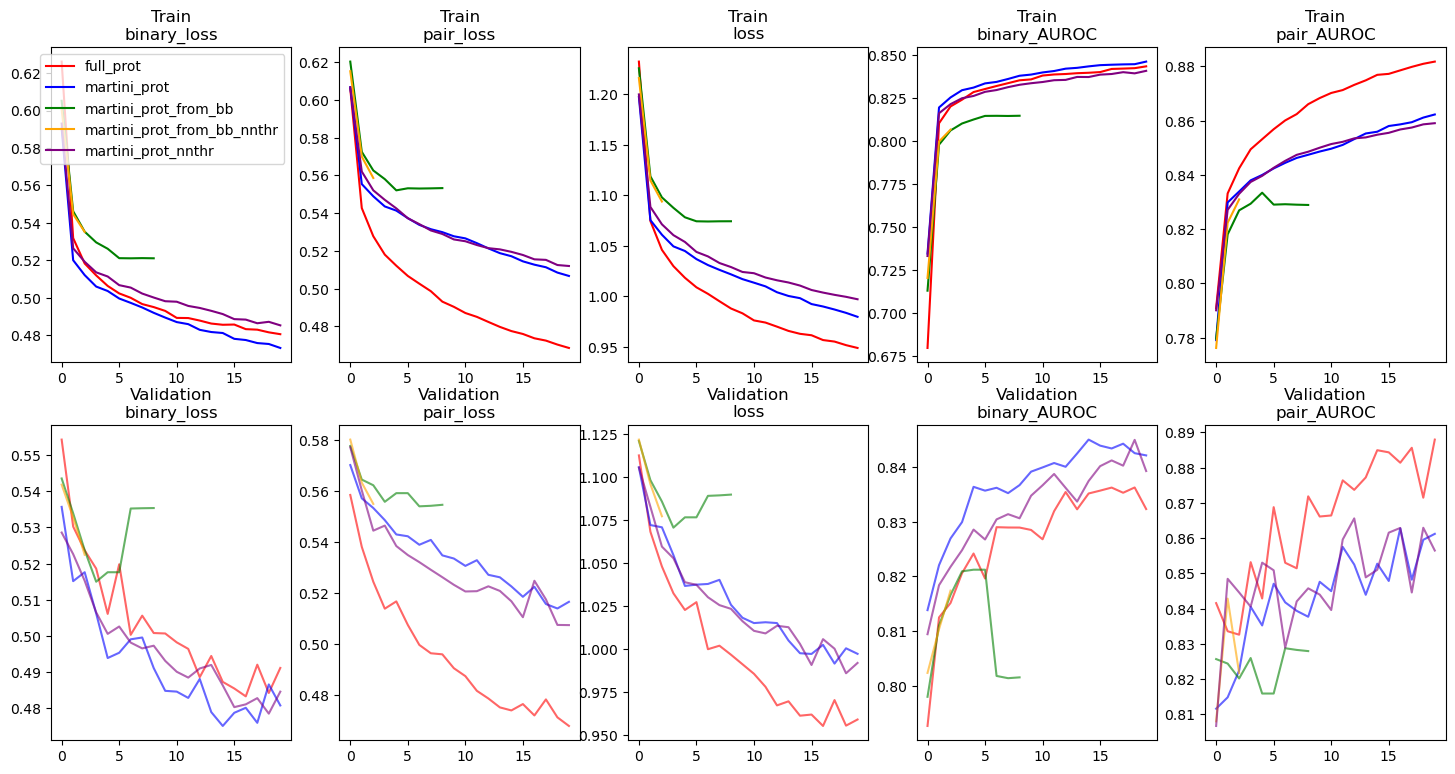

In [8]:
fig, ax=plt.subplots(2,5 , figsize=(18,9))
ax=ax.T.reshape(-1)
draw_curves(ax,log_dict, keys=['binary_loss', 
                               'complementary_loss', 
                               'loss', 
                               'binary_AUROC', 
                               'complementary_AUROC'], epoch=20)